<a href="https://colab.research.google.com/github/punkmic/Predict-survival-on-the-Titanic-with-XGBoost/blob/master/Predict_survival_on_the_Titanic_with_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Predicting who survives on the Titanic with XGBoost**

In [46]:
!git clone https://github.com/punkmic/Predict-survival-on-the-Titanic-with-XGBoost.git

Cloning into 'Predict-survival-on-the-Titanic-with-XGBoost'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 7 (delta 1), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (7/7), done.


### Print table of features

In [47]:
# read table features
pd.read_csv('/content/Predict-survival-on-the-Titanic-with-XGBoost/tintanic_features.csv')

,Variable,Definition,Key
0,survival,Survival,"0 = No, 1 = Yes"
1,pclass,Ticket class,"1 = 1st, 2 = 2nd, 3 = 3rd"
2,sex,Sex,NaN
3,Age,Age in years,NaN
4,sibsp,# of siblings / spouses aboard the Titanic,NaN
5,parch,# of parents / children aboard the Titanic,NaN
6,ticket,Ticket number,NaN
7,fare,Passenger fare,NaN
8,cabin,Cabin number,NaN
9,embarked,Port of Embarkation,"C = Cherbourg, Q = Queenstown, S = Southampton"


In [27]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.metrics import r2_score, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score
# load XGBoost
try:
  import xgboost as xgb
except:
  !pip install xgboost

### Load dataset using fetch_openml method from sklean

In [2]:
DATASET = "titanic"
X, y = fetch_openml(DATASET, version=1, as_frame=True, return_X_y=True)
X.drop(['boat', 'body', 'home.dest'], axis=1, inplace=True)

### Split data into train and test

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [38]:
# Print information
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1047 entries, 134 to 727
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   pclass    1047 non-null   float64 
 1   name      1047 non-null   object  
 2   sex       1047 non-null   category
 3   age       832 non-null    float64 
 4   sibsp     1047 non-null   float64 
 5   parch     1047 non-null   float64 
 6   ticket    1047 non-null   object  
 7   fare      1046 non-null   float64 
 8   embarked  1045 non-null   category
dtypes: category(2), float64(5), object(2)
memory usage: 67.7+ KB


In [39]:
# Print the first top 3 rows
X_train.head(3)

,pclass,name,sex,age,sibsp,parch,ticket,fare,embarked
134,1.0,"Goldenberg, Mrs. Samuel L (Edwiga Grabowska)",female,NaN,1.0,0.0,17453,89.1042,C
911,3.0,"Kalvik, Mr. Johannes Halvorsen",male,21.0,0.0,0.0,8475,8.4333,S
264,1.0,"Simonius-Blumer, Col. Oberst Alfons",male,56.0,0.0,0.0,13213,35.5000,C


### Preprocessing 
- Remove missing values

In [21]:
# Check missing values
X_train.isnull().sum() / len(X_train) * 100

pclass       0.000000
name         0.000000
sex          0.000000
age         20.534862
sibsp        0.000000
parch        0.000000
ticket       0.000000
fare         0.095511
cabin       77.172875
embarked     0.191022
dtype: float64

Observe that approximately 78% of rows have no information about the cabin that's said let's drop rows having missing cabin value.

In [22]:
# Drop cabin feature
X_train.drop(['cabin'], axis=1, inplace=True)
X_test.drop(['cabin'], axis=1, inplace=True)

### Compute correlation between features

Correlation is a statistical measure that describes the strength of a linear relationship between two variables. It can be useful for selecting features to feed into a machine learning model, as highly correlated features may contain redundant information and can negatively impact model performance.

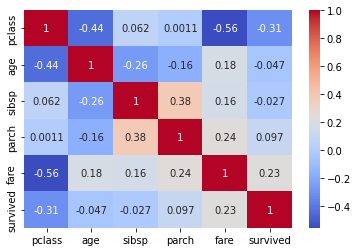

In [29]:
# Concat X_train and y_train
X_comb = pd.concat([X_train, y_train.astype(float)], axis=1)

# Compute the Pearson correlation coefficient between the features
corr = X_comb.corr(method='pearson')

# Plot the correlation heatmap
sns.heatmap(corr, annot=True, cmap = "coolwarm")
plt.show()

As the heatmap shows, there is a weak correlation between parch and sibsp features. One way to solve this problem is to use feature engineering to create a new feature. Feature engineering is the process of designing and creating features that can be used to train machine learning models. It involves selecting relevant features from raw data, extracting and constructing new features from existing ones, and transforming features to make them more suitable for modeling.

### Evaluation

Scikit-learn APIS include functions that let you evaluate models using their default evaluation metrics